# Measuring centroids and position angles for the LoVoCCS sample

Here we measure the centroid coordinate and position angle of the intra-cluster medium X-ray emission of the LoVoCCS sample. The centroid is the first moment of the 2D surface brightness distribution (the average position, weighted by the surface brightness) and acts as an alternate (to the peak) definition of the central coordinate - it is also useful when combined with the peak, allowing for the creation of a metric for cluster disturbedness (a word I suspect I just made up).

The second moment of the 2D surface brightness distribution is essentially the covariance matrix, which can then be diagonalised to find the rotation angle (which can be turned into a position angle) and the axis length ratio of the (assumed) ellipse that describes the ICM emission.

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM
from shutil import rmtree
import os
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

import xga
xga.NUM_CORES = 5
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

%matplotlib inline

## Setting up necessary directories

Here we ensure that the directories we need to store the outputs in have been created:

In [2]:
if not os.path.exists("../../outputs/figures/positions/"):
    os.makedirs("../../outputs/figures/positions/")
    
if not os.path.exists("../../outputs/coordinates"):
    os.makedirs("../../outputs/coordinates/")
    
if not os.path.exists("../../outputs/cluster_visualisations/centroid_posangle_meas/"):
    os.makedirs("../../outputs/cluster_visualisations/centroid_posangle_meas/")

## Defining any useful functions

In [ ]:
def centroid_shape_estimate(rel_src, ap_rad, cent_coord=None, log_data=False):
    
    cur_rt = src.get_combined_ratemaps()
    cont_mask = src.get_interloper_mask()
    
    if ap_rad is not None:
        ap_mask = src.get_custom_mask(ap_rad, remove_interlopers=False, central_coord=cent_coord)
    else:
        ap_mask = np.ones(cur_rt.shape)
        
    tot_mask = ap_mask*cont_mask
    
    data_cp = cur_rt.data.copy()
    if not log_data:
        msk_data = data_cp*tot_mask
    else:
        msk_data = np.log10(data_cp*tot_mask)
        msk_data[np.isinf(msk_data)] = 0
    
    norm_data = msk_data / msk_data.sum()
    
    arr_x, arr_y = np.meshgrid(np.arange(0, norm_data.shape[1], ), np.arange(0, norm_data.shape[0]))
    
    x_cen_pix = (norm_data*arr_x).sum()
    y_cen_pix = (norm_data*arr_y).sum()
    cen_pix = [x_cen_pix, y_cen_pix]
    cen_pix_quan = Quantity([x_cen_pix, y_cen_pix], 'pix')
    

#     cen_deg = cur_rt.coord_conv(cen_pix, 'deg')
    covar = np.zeros((2, 2))
    covar[0, 0] = (norm_data*np.square(arr_x - cen_pix[0])).sum()
    covar[1, 1] = (norm_data*np.square(arr_y - cen_pix[1])).sum()
    covar[0, 1] = (norm_data * (arr_x - cen_pix[0]) * (arr_y - cen_pix[1])).sum()
    covar[1, 0] = covar[0, 1]
    
#     np.arctan2(rec_x, rec_y) - start_ang
    
    # TODO Try to normalise this output + ensure that it is North of East (does my head in)
    theta = 0.5*np.arctan((2*covar[1, 0]) / (covar[0, 0]-covar[1, 1]))*(180/np.pi)
    
    mod_theta = theta % 360
    
    if ((covar[1, 0] > 0 and (covar[0, 0] - covar[1, 1]) < 0) or 
            (covar[1, 0] < 0 and (covar[0, 0] - covar[1, 1]) < 0)):
        mod_theta = mod_theta - 90
    
    # This is Megan's paper version - generally seems to be at 90 degree angle to the one above - it may deal
    #  with the degeneracy of the tan function better however
#     theta = np.arctan((np.sqrt(np.square((covar[0, 0] - covar[1, 1]) / covar[0, 1]) + 1) - 
#                       ((covar[0, 0] - covar[1, 1])/(2*covar[0, 1]))))* (180/np.pi)
    
    eig_pl = ((covar[0, 0] + covar[1, 1]) + np.sqrt((covar[0, 0] - covar[0, 0])**2 + 4*covar[0, 1]**2)) / 2
    eig_mi = ((covar[0, 0] + covar[1, 1]) - np.sqrt((covar[0, 0] - covar[0, 0])**2 + 4*covar[0, 1]**2)) / 2

    x_s = np.sqrt(eig_pl)
    y_s = np.sqrt(eig_mi)
    
    return cur_rt.coord_conv(cen_pix_quan, 'deg'), mod_theta, x_s, y_s
    

## Reading in the sample

We read in the LoVoCCS sample relevant to the current work:

In [4]:
samp = pd.read_csv("../../sample_files/X-LoVoCCSI.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: "LoVoCCS-" + str(x))
samp

,LoVoCCSID,Name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,LoVoCCS_name
0,1,A2029,227.734300,5.745471,0.0766,1.3344,227.73000,5.720000,227.734300,5.745471,LoVoCCS-1
1,2,A401,44.740000,13.580000,0.0739,1.2421,44.74000,13.580000,NaN,NaN,LoVoCCS-2
2,4,A85,10.458750,-9.301944,0.0555,1.2103,10.45875,-9.301944,NaN,NaN,LoVoCCS-4
3,5,A3667,303.157313,-56.845978,0.0556,1.1990,303.13000,-56.830000,303.157313,-56.845978,LoVoCCS-5
4,7,A3827,330.480000,-59.950000,0.0980,1.1367,330.48000,-59.950000,NaN,NaN,LoVoCCS-7
...,...,...,...,...,...,...,...,...,...,...,...
61,121,A3128,52.466189,-52.580728,0.0624,0.8831,52.50000,-52.600000,52.466189,-52.580728,LoVoCCS-121
62,122,A1023,157.000000,-6.800000,0.1176,0.8553,157.00000,-6.800000,NaN,NaN,LoVoCCS-122
63,123,A3528,193.670000,-29.220000,0.0544,0.8855,193.67000,-29.220000,NaN,NaN,LoVoCCS-123
64,131,A761,137.651250,-10.581111,0.0916,0.8627,137.65125,-10.581111,NaN,NaN,LoVoCCS-131


# TODO OBVIOUSLY REMOVE THIS
samp = samp.sample(5, random_state=907)
samp

## Defining an XGA ClusterSample

As we do not have observation cleaning turned on, we manually remove clusters that we know are excluded from our other analyses due to inadequate XMM data:

In [ ]:
samp = samp[samp['LoVoCCSID'].isin(['41C'])]

In [5]:
srcs = ClusterSample(samp['start_ra'].values, samp['start_dec'].values, samp['MCXC_Redshift'].values, 
                     samp['LoVoCCS_name'].values, r500=Quantity(samp['MCXC_R500'].values, 'Mpc'), use_peak=False, 
                     clean_obs=False)
srcs.info()

Setting up Galaxy Clusters:  32%|███▏      | 20/63 [02:03<02:15,  3.16s/it]

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it]


-----------------------------------------------------
Number of Sources - 63
Redshift Information - True
Sources with ≥1 detection - 59 [94%]
-----------------------------------------------------



## 

In [28]:
cents = {}
for src in srcs:
    cents[src.name] = []
    for ap in Quantity(np.linspace(100, 2000, 20), 'kpc'):
        cur_cen, cur_ang, cur_x_scale, cur_y_scale = centroid_shape_estimate(src, ap)
        cents[src.name].append(cur_cen)
        
#     cur_cen, cur_ang, cur_x_scale, cur_y_scale = centroid_shape_estimate(src, Quantity(600, 'kpc'))
#     cur_cen, cur_ang, cur_x_scale, cur_y_scale = centroid_shape_estimate(src, Quantity(600, 'kpc'), 
# log_data=True)
    
#     cur_rt = src.get_combined_ratemaps()
    
#     print(src.name, cur_cen, cur_ang, cur_x_scale, cur_y_scale)
    
#     plt.figure(figsize=(8, 8))
#     ax = plt.gca()
#     cur_rt.get_view(ax, Quantity([cur_cen, src.ra_dec]))
    
#     cur_cen_pix = cur_rt.coord_conv(cur_cen, 'pix')
#     ell = Ellipse(cur_cen_pix.value, cur_x_scale*5, cur_y_scale*5, cur_ang, fc='none', ec='white', )
#     ax.add_patch(ell)
    
#     plt.tight_layout()
#     plt.show()

#     print('')

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


## Effect of different apertures

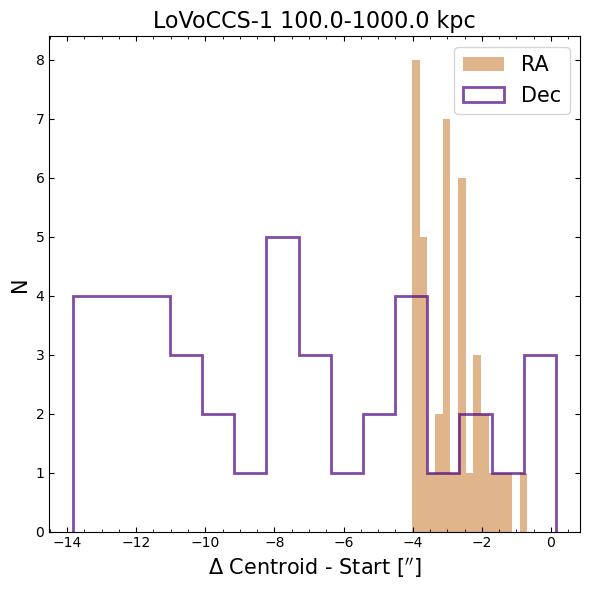

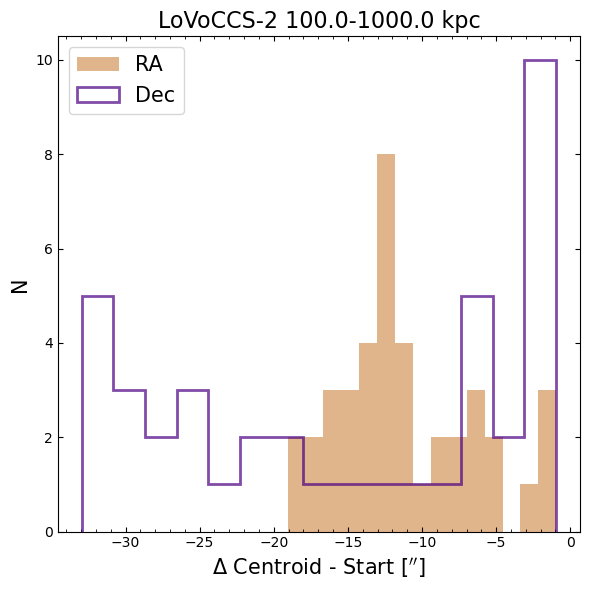

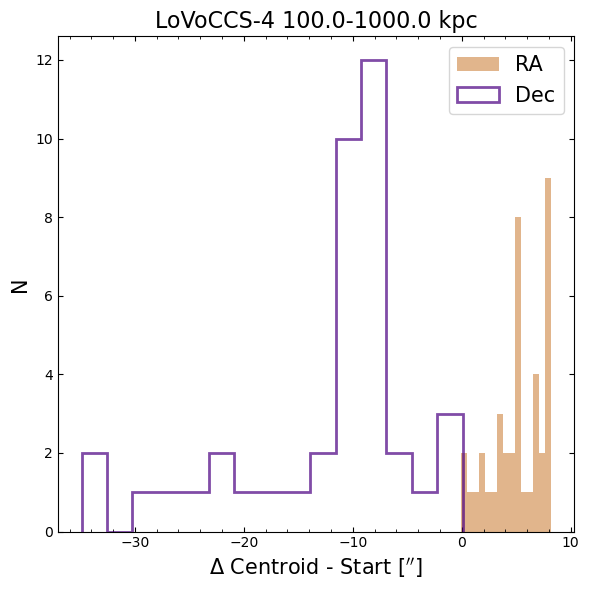

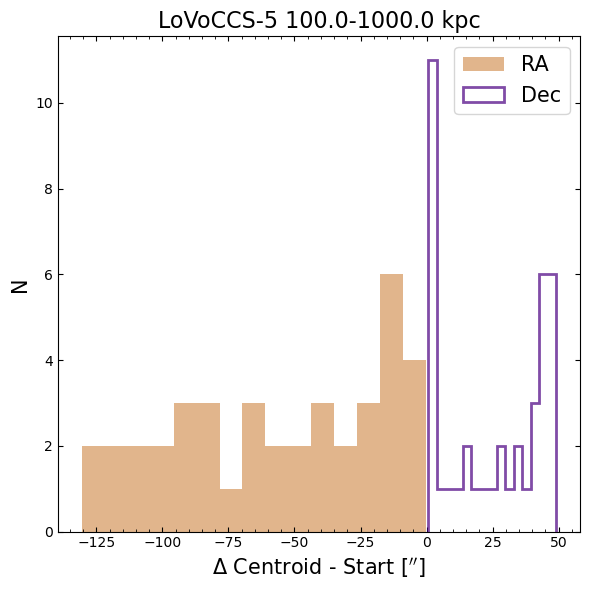

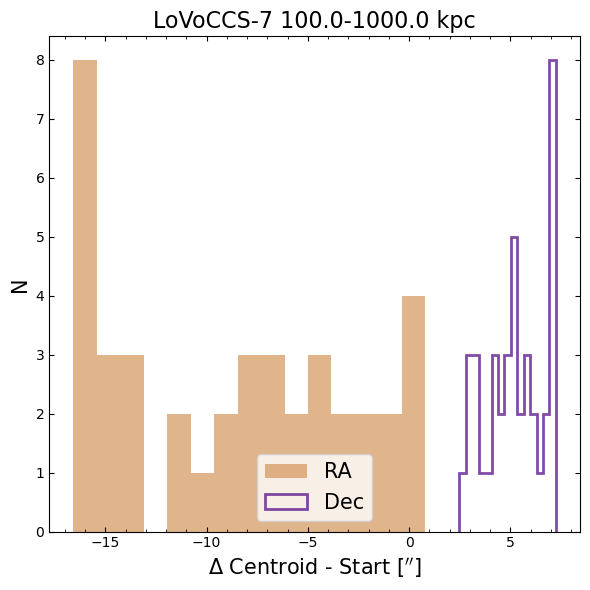

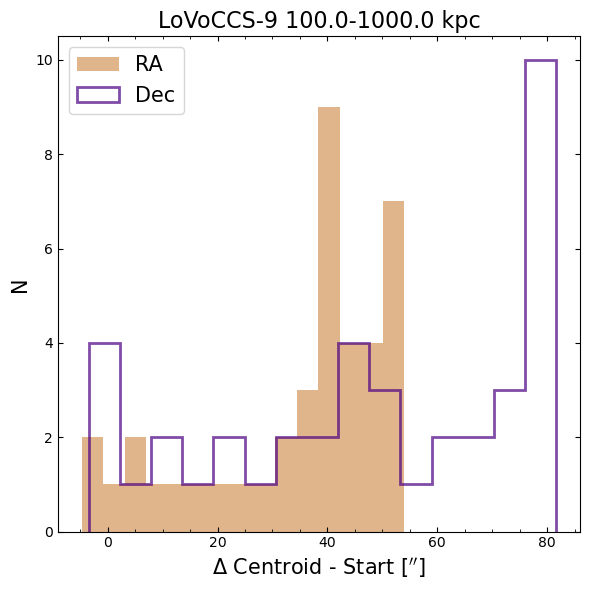

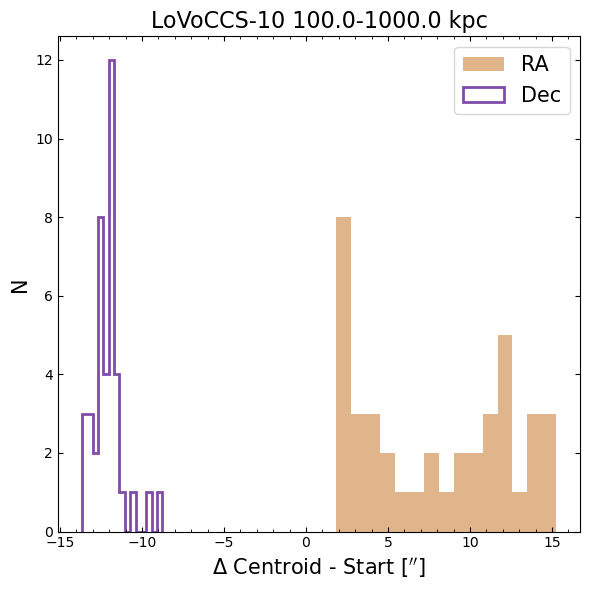

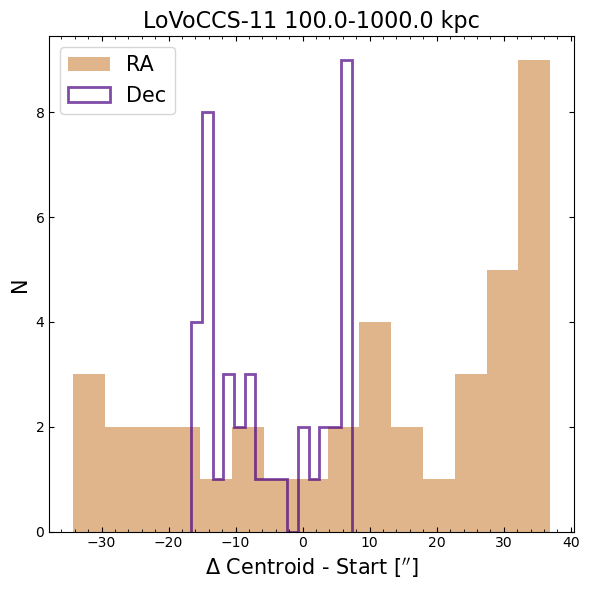

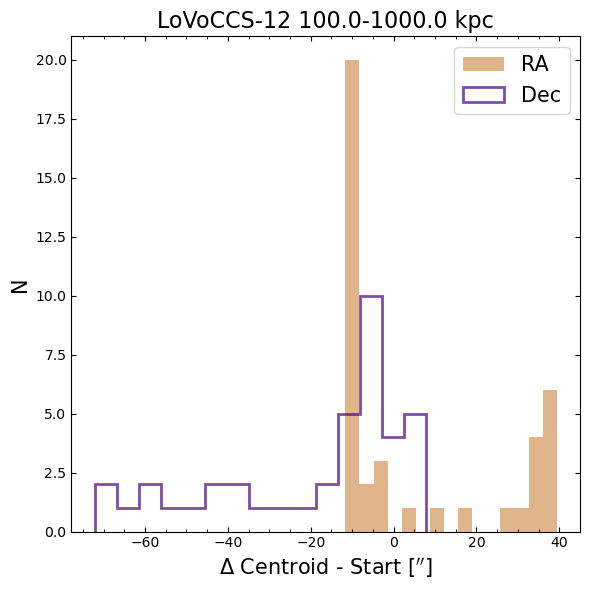

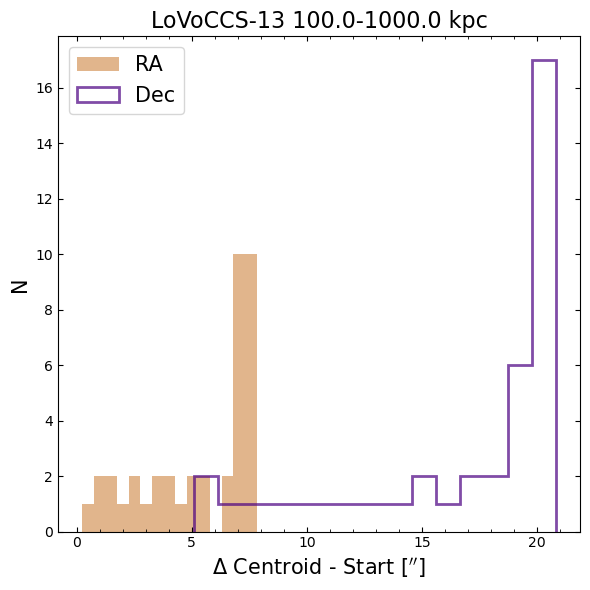

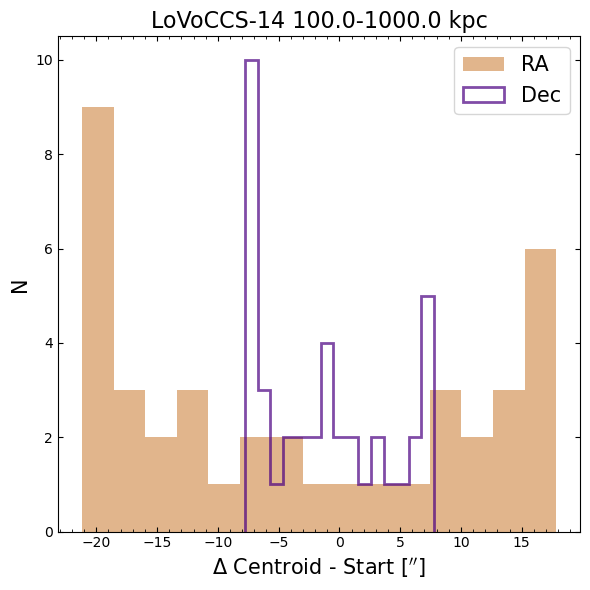

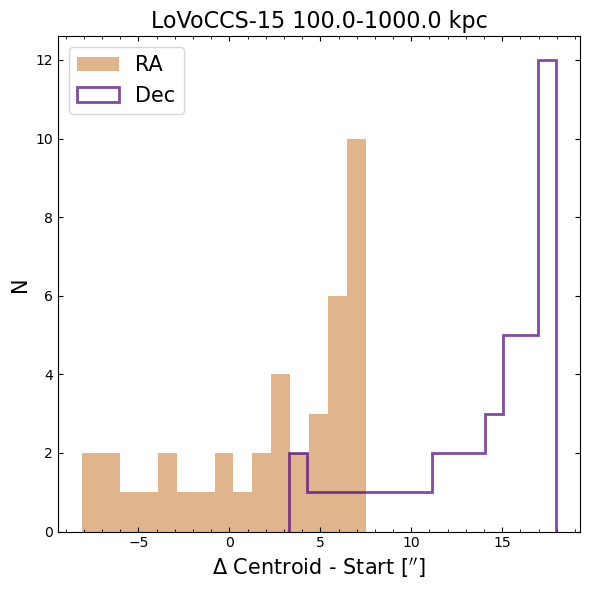

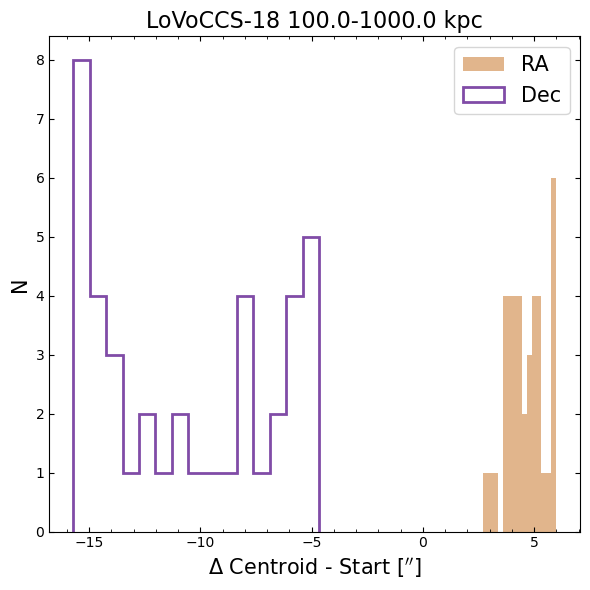

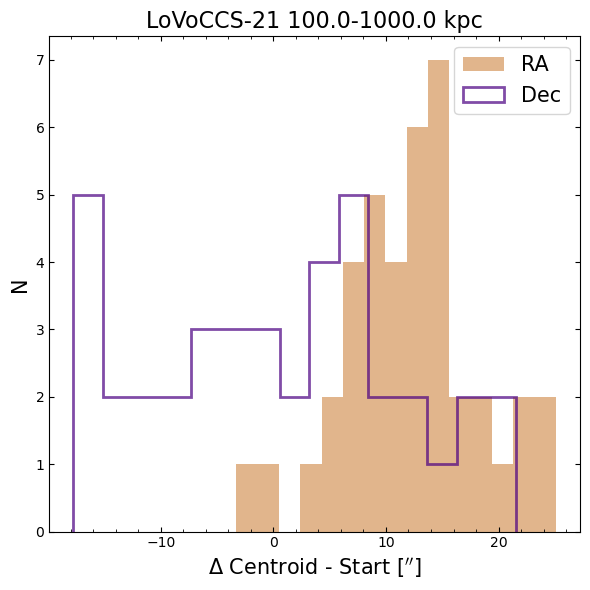

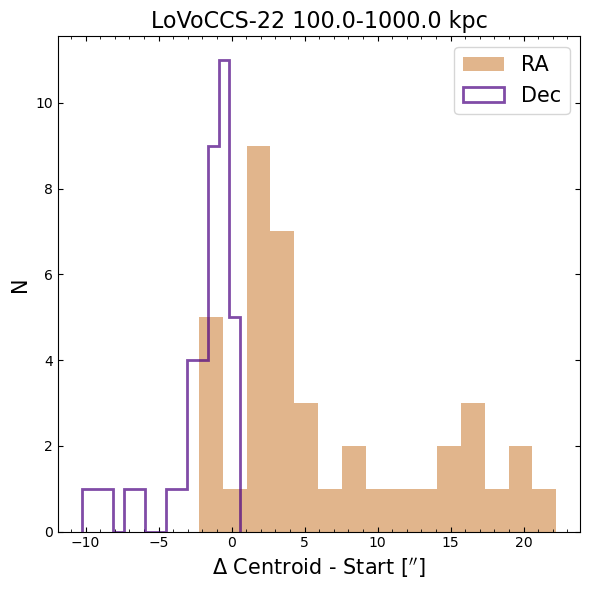

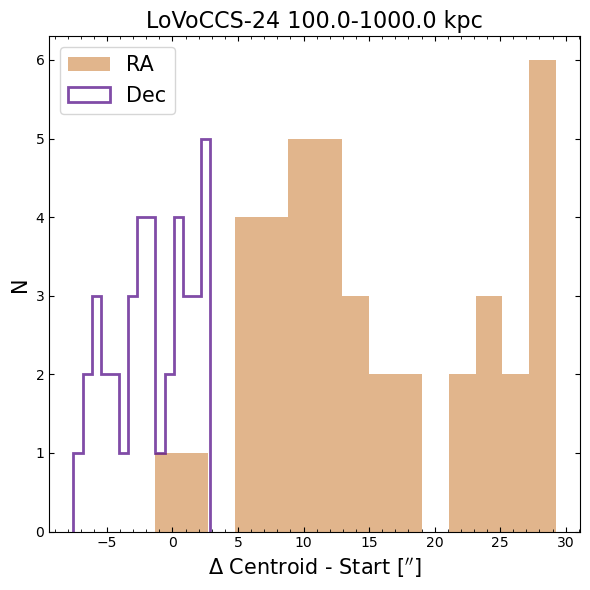

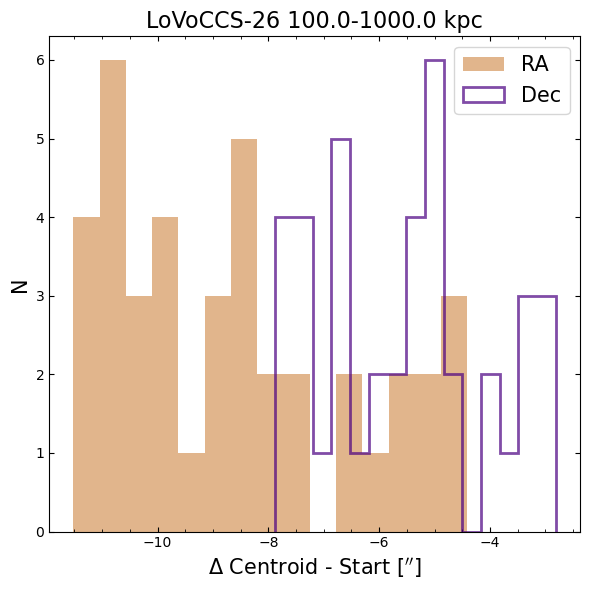

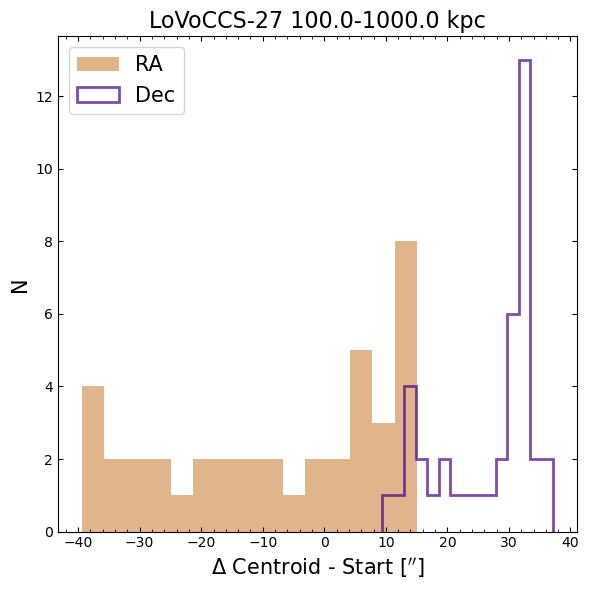

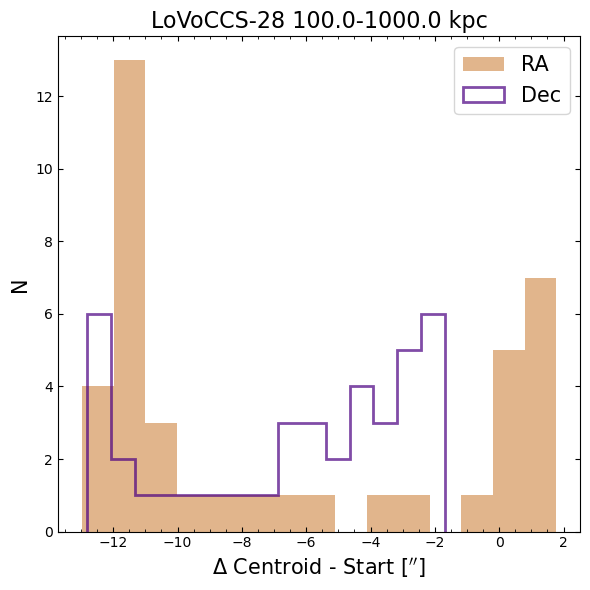

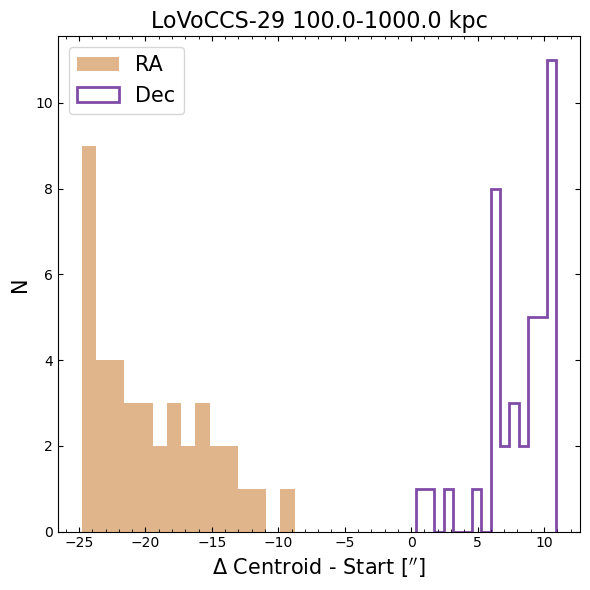

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


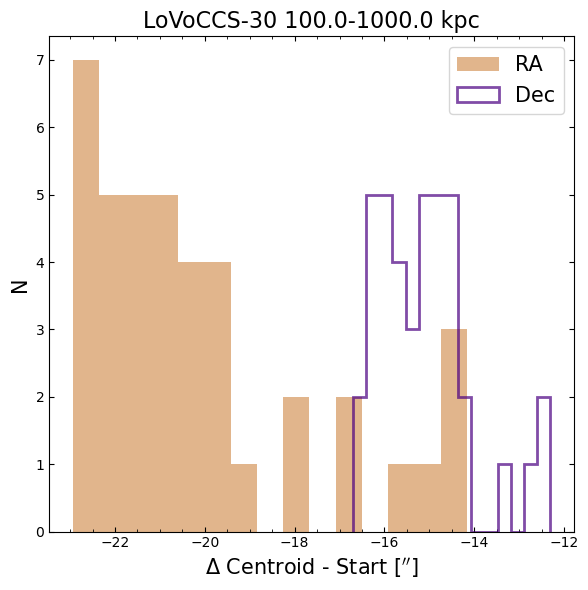

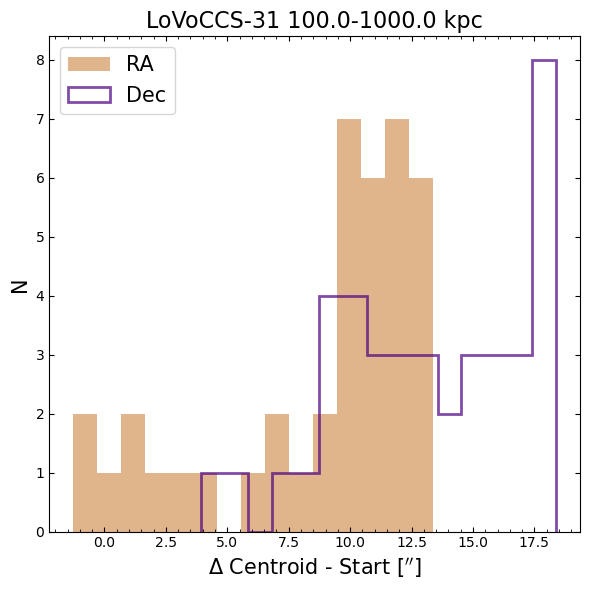

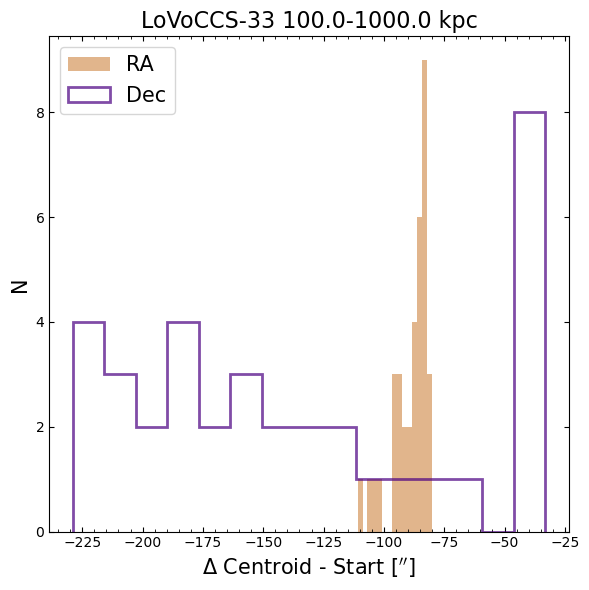

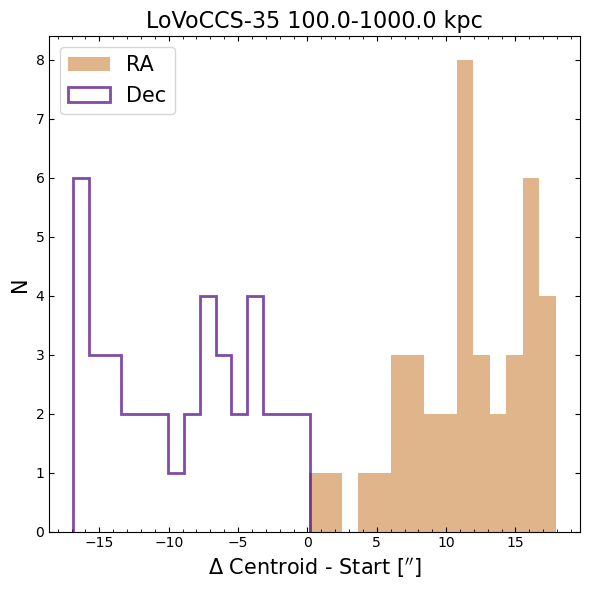

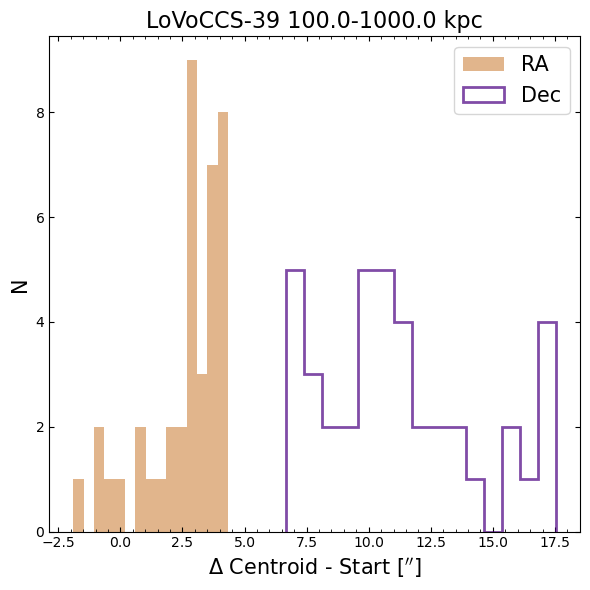

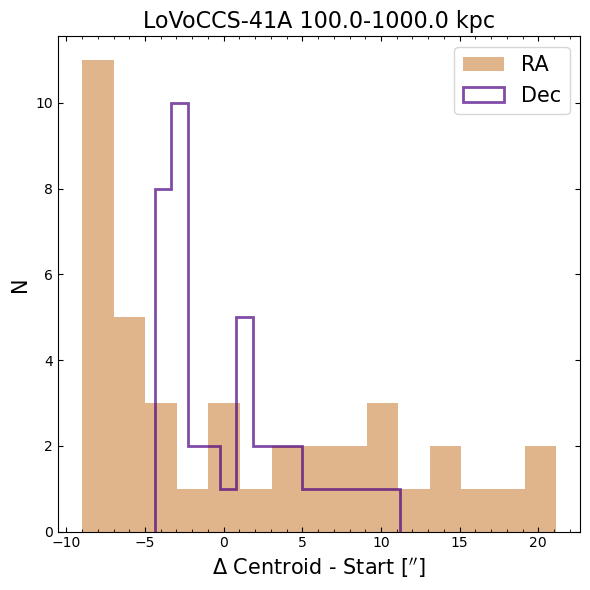

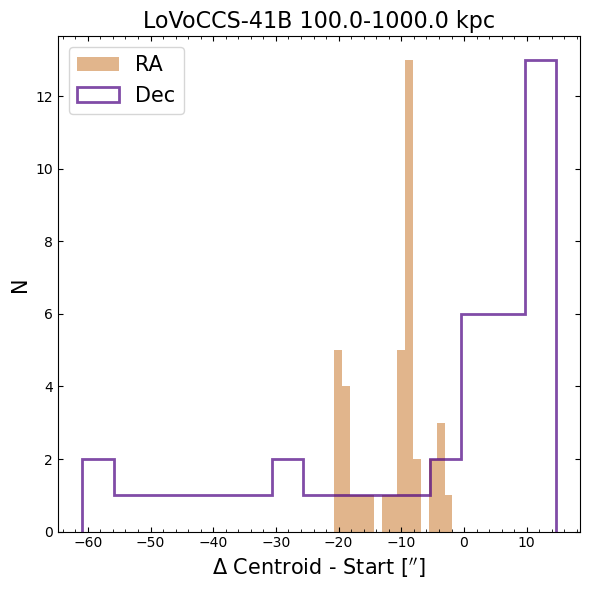

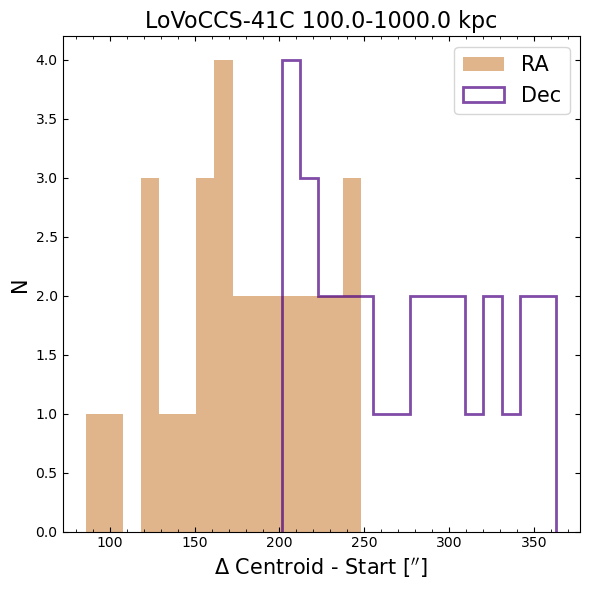

In [ ]:
cents = {}
for src in srcs:
    cents[src.name] = []
    ap_rng = Quantity(np.linspace(100, 1000, 40), 'kpc')
    for ap in ap_rng:
        cur_cen, cur_ang, cur_x_scale, cur_y_scale = centroid_shape_estimate(src, ap)
        cents[src.name].append(cur_cen)
    
    rel_cents = Quantity(cents[src.name])
    
#     fig, ax_arr = plt.subplots(1, 2, figsize=(12, 6))
    plt.figure(figsize=(6, 6))
#     for ax in ax_arr:
    
    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.tick_params(which='minor', left=False, right=False)

    ax.hist((rel_cents[:, 0].value - src.ra_dec[0].value)*3600, bins=15, histtype='stepfilled', color='peru', 
            lw=2, alpha=0.6, label="RA")
    ax.hist((rel_cents[:, 1].value - src.ra_dec[1].value)*3600, bins=15, color='indigo', histtype='step', 
            alpha=0.7, label="Dec", lw=2)
    
    plt.title(src.name + " ({l}-{u} kpc)".format(l=ap_rng[0].value.astype(int), 
                                                 u=ap_rng[-1].value.astype(int)), fontsize=16)
    plt.ylabel("N", fontsize=15)
    plt.xlabel(r"$\Delta$ Centroid - Start [$^{\prime\prime}$]", fontsize=15)
    plt.legend(loc='best', fontsize=15)
    plt.tight_layout()
    
    plt.show()
    plt.close('all')